In [ ]:
!pip install nengo
!pip install nengo_ocl

In [ ]:
import nengo
# import nengo_ocl
import numpy as np
import matplotlib.pyplot as plt
import gym
from nengo.utils.matplotlib import rasterplot

In [ ]:
np.random.seed(0)

# master class that performs environment interaction and learning
class Master():
    def __init__(self,
                 env_name,
                 n_actor,
                 n_critic,
                 n_place,
                 dt,
                 V_0,
                 v,
                 tau_r,
                 stepSize=1,
                 actor_lr=0.05,
                 critic_lr=0.2):

        # gym
        self.env = gym.make(env_name)
        self.env.seed(0)
        if type(self.env.action_space) == gym.spaces.discrete.Discrete:
            self.action_dim = self.env.action_space.n
            self.discrete_actions = True
        else:
            self.action_dim = self.env.action_space.shape[0]
            self.discrete_actions = False

        if env_name == 'Pendulum-v1':
            self.F_max = 2
            self.actor_directions = 2 * self.F_max * np.arange(n_actor) / n_actor - self.F_max
            self.min_reward = -16.2736044

        self.state_dim = self.env.observation_space.shape[0]
        self.stepsize = stepSize
        self.dt = dt
        self.state = self.env.reset()
        self.reward = 0
        self.done = False
        self.reward_history = []
        self.totalReward = 0
        self.max_steps = 150
        self.step_num = 0

        self.V_0 = V_0
        self.v = v
        self.tau_r = tau_r
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        # self.place_actor_weights = np.load('cache/place_actor_weights.npy')
        # self.place_critic_weights = np.load('cache/place_critic_weights.npy')
        self.place_actor_weights = np.random.normal(loc=0.5, scale=0.1, size=(n_actor, n_place))
        self.place_critic_weights = np.random.normal(loc=0.5, scale=0.1, size=(n_critic, n_place))
        self.w_min = 0
        self.w_max = 3

    def step(self, t, action):
        if int(t / self.dt) % self.stepsize != 0:
            return
        self.step_num += 1
#         self.env.render()
        self.state, self.reward, self.done, _ = self.env.step(action)
        self.totalReward += self.reward
        # if self.step_num == self.max_steps:
        if self.done:
#             self.reward = -2 # penalize end of episode
            self.totalReward += self.reward
            self.reward_history.append(self.totalReward)
            self.state = self.env.reset()
            self.totalReward = 0
            self.step_num = 0

    def sensor(self,t):
        return self.state

    def calc_td_error(self, t, critic_rates):
#         print('td', critic_rates)
        return self.v * np.mean(critic_rates*self.dt) - self.V_0/self.tau_r + self.reward

    def outer(self, t, x):
        X_conv_eps = x[:n_place]* self.dt
        Y = x[n_place:]* self.dt
#         print('outer', X_conv_eps, Y)
        return np.outer(Y, X_conv_eps).flatten()

    def actor(self, t, x):
        dVdw = x[:n_place * n_actor].reshape(n_actor, n_place)
        place_spikes = x[n_place * n_actor:-1] * self.dt
        td_error = x[-1]
        self.place_actor_weights += self.actor_lr * td_error * dVdw
        self.place_actor_weights = np.clip(self.place_actor_weights, a_min=self.w_min, a_max=self.w_max)
#         print('actor', np.dot(self.place_actor_weights, place_spikes))
#         print('actor', self.place_actor_weights, place_spikes)
        return np.dot(self.place_actor_weights, place_spikes)

    def critic(self, t, x):
        dVdw = x[:n_place * n_critic].reshape(n_critic, n_place)
        place_spikes = x[n_place * n_critic:-1] * self.dt
        td_error = x[-1]
        self.place_critic_weights += self.critic_lr * td_error * dVdw
        self.place_critic_weights = np.clip(self.place_critic_weights, a_min=self.w_min, a_max=self.w_max)

        return np.dot(self.place_critic_weights, place_spikes)

    def select_action(self, t, actor_rates):
#         return self.actor_directions[np.argmax(actor_rates)]
#         print(actor_rates)
        rate_sum = np.sum(actor_rates*self.dt)
        if rate_sum == 0: return 0
        return np.dot(actor_rates*self.dt, self.actor_directions) / rate_sum

    def calc_value(self, t, critic_rates):
        return self.v * np.mean(critic_rates*self.dt) + self.V_0

# v = 2
# V_0 = -40
V_0 = -16
v = 30
tau_r = 4 # reward time constant
v_k = 50e-3
tau_k = 200e-3
eps_0 = 20e-3
tau_m = 20e-3
tau_s = 5e-3
tau_gamma = 50e-3
v_gamma = 20e-3

dt = 1e-3
n_actor = 40
n_critic = 50
n_place = 100
place_radius = 5
actor_radius = 2
critic_radius = 8

stepSize = 1
actor_lr = 0.05
critic_lr = 0.2

lateral_sigma = 3
lateral_inhibition = 0.1

actor_lambda = 0.5
w_plus = 30
w_minus = -60
lateral_stability_const = (n_actor/actor_lambda/2)**2

# env_name = 'CartPole-v0'
# env_name = 'MountainCarContinuous-v0'
env_name = 'Pendulum-v1'
master = Master(
    env_name=env_name,
    n_actor=n_actor,
    n_critic=n_critic,
    n_place=n_place,
    dt=dt,
    V_0=V_0,
    v=v,
    tau_r=tau_r,
    stepSize=stepSize,
    actor_lr=actor_lr,
    critic_lr=critic_lr
)
model = nengo.Network(seed=0)


with model:
    state_node = nengo.Node(output=master.sensor)
    place = nengo.Ensemble(n_neurons=n_place,
                           dimensions=master.state_dim,
                           radius=place_radius)
    nengo.Connection(state_node, place)

    #####################################################

    actor = nengo.Ensemble(n_neurons=n_actor,
                           dimensions=master.action_dim,
                           radius=actor_radius)


#     paper lateral actor connections
#     lateral_weight_denom = 2*np.sum([
#         np.exp((k/actor_lambda)**2 - lateral_stability_const)
#         for k in range(1, int(n_actor/2))
#     ])
#     print('d',lateral_weight_denom)
#     for k in range(n_actor):
#         for k_p in range(n_actor):
#             if k == k_p: continue
#             lateral_weight = w_minus/n_actor \
#                 + w_plus * np.exp(((k - k_p)/actor_lambda)**2 - lateral_stability_const) / lateral_weight_denom
#             print('w',lateral_weight)
#             if lateral_weight == 0: continue
#             nengo.Connection(actor.neurons[k],
#                              actor.neurons[k_p],
#                              transform=[lateral_weight])

#   gaussian lateral actor connections
    lateral_weights = np.zeros((n_actor, n_actor))
    for k in range(n_actor):
        for k_p in range(n_actor):
            if k == k_p: continue # no self connection
            lateral_weight = (1+lateral_inhibition)*np.exp(-((k - k_p)/lateral_sigma)**2) - lateral_inhibition
            lateral_weights[k,k_p] = lateral_weight
    nengo.Connection(actor.neurons, actor.neurons, transform=lateral_weights)

    actor_outer = nengo.Node(master.outer,
                            size_in=n_place + n_actor,
                            size_out=n_place * n_actor)
    # convolve place spikes with epsilon
    nengo.Connection(place.neurons,
                     actor_outer[:n_place],
                     synapse=tau_m,
                     transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(place.neurons,
                     actor_outer[:n_place],
                     synapse=tau_s,
                     transform=-((eps_0 * tau_s) / (tau_m - tau_s)))
    # Pass raw actor spikes into actor_outer
    nengo.Connection(actor.neurons, actor_outer[n_place:], synapse=None)

    actor_learn = nengo.Node(master.actor,
                            size_in=n_place * n_actor + n_place + 1,
                            size_out=n_actor)
    # convolve actor_outer output with k / tau_r
    nengo.Connection(actor_outer,
                     actor_learn[:n_place * n_actor],
                     synapse=tau_k,
                     transform=tau_k/((tau_k - v_k)*tau_r))
    nengo.Connection(actor_outer,
                     actor_learn[:n_place * n_actor],
                     synapse=v_k,
                     transform=(-v_k)/((tau_k - v_k)*tau_r))
    # Pass convolved place spikes with epsilon into actor_learn
    nengo.Connection(place.neurons,
                     actor_learn[n_place * n_actor:-1],
                     synapse=tau_m,
                     transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(place.neurons,
                     actor_learn[n_place * n_actor:-1],
                     synapse=tau_s,
                     transform=-((eps_0 * tau_s) / (tau_m - tau_s)))

    # connect actor_learn to actor neurons
    nengo.Connection(actor_learn, actor.neurons, synapse=None)

    action_selection_node = nengo.Node(output=master.select_action, size_in=n_actor)
    nengo.Connection(actor.neurons,
                     action_selection_node,
                     synapse=tau_gamma,
                     transform=tau_gamma/(tau_gamma - v_gamma))
    nengo.Connection(actor.neurons,
                     action_selection_node,
                     synapse=v_gamma,
                     transform=(-v_gamma)/(tau_gamma - v_gamma))

    step_node = nengo.Node(output=master.step, size_in=master.action_dim)
    nengo.Connection(action_selection_node, step_node, synapse=None)

    #####################################################

    critic = nengo.Ensemble(n_neurons=n_critic,
                            dimensions=1,
                            radius=critic_radius)

    critic_outer = nengo.Node(master.outer,
                              size_in=n_place + n_critic,
                              size_out=n_place * n_critic)
    # convolve place spikes with epsilon
    nengo.Connection(place.neurons,
                     critic_outer[:n_place],
                     synapse=tau_m,
                     transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(place.neurons,
                     critic_outer[:n_place],
                     synapse=tau_s,
                     transform=-((eps_0 * tau_s) / (tau_m - tau_s)))
    # Pass raw critic spikes into critic_outer
    nengo.Connection(critic.neurons, critic_outer[n_place:], synapse=None)

    critic_learn = nengo.Node(master.critic,
                              size_in=n_place * n_critic + n_place + 1,
                              size_out=n_critic)
    # convolve critic_outer output with k / tau_r
    nengo.Connection(critic_outer,
                     critic_learn[:n_place * n_critic],
                     synapse=tau_k,
                     transform=tau_k/((tau_k - v_k)*tau_r))
    nengo.Connection(critic_outer,
                     critic_learn[:n_place * n_critic],
                     synapse=v_k,
                     transform=(-v_k)/((tau_k - v_k)*tau_r))
    # Pass convolved place spikes with epsilon into critic_learn
    nengo.Connection(place.neurons,
                     critic_learn[n_place * n_critic:-1],
                     synapse=tau_m,
                     transform=((eps_0 * tau_m) / (tau_m - tau_s)))
    nengo.Connection(place.neurons,
                     critic_learn[n_place * n_critic:-1],
                     synapse=tau_s,
                     transform=-((eps_0 * tau_s) / (tau_m - tau_s)))

    # connect critic_learn to critic neurons
    nengo.Connection(critic_learn, critic.neurons, synapse=None)

    td_error_node = nengo.Node(output=master.calc_td_error, size_in=n_critic)
    # convolve critic spikes with (K' - K/tau_r)
    nengo.Connection(critic.neurons,
                     td_error_node,
                     synapse=nengo.Lowpass(tau=tau_k),
                     transform=((-tau_r - tau_k)/(tau_r*(tau_k-v_k))))
    nengo.Connection(critic.neurons,
                     td_error_node,
                     synapse=nengo.Lowpass(tau=v_k),
                     transform=((tau_r + v_k)/(tau_r*(tau_k-v_k))))

    nengo.Connection(td_error_node, actor_learn[-1], synapse=None)
    nengo.Connection(td_error_node, critic_learn[-1], synapse=None)

    value_node = nengo.Node(output=master.calc_value, size_in=n_critic)
    nengo.Connection(critic.neurons,
                     value_node,
                     synapse=tau_k,
                     transform=tau_k/(tau_k - v_k))
    nengo.Connection(critic.neurons,
                     value_node,
                     synapse=v_k,
                     transform=(-v_k)/(tau_k - v_k))


#     err_probe = nengo.Probe(td_error_node, synapse=None, sample_every=dt*stepSize)
    action_probe = nengo.Probe(action_selection_node, synapse=None, sample_every=dt*stepSize)
    value_probe = nengo.Probe(value_node, synapse=None, sample_every=dt*stepSize)
#     place_probe = nengo.Probe(place, synapse=None, sample_every=dt*stepSize)
#     state_probe = nengo.Probe(state_node, synapse=None, sample_every=dt*stepSize)

#     critic_spikes = nengo.Probe(critic.neurons)
#     actor_spikes = nengo.Probe(actor.neurons)
#     place_spikes = nengo.Probe(place.neurons)

sim = nengo.Simulator(model, dt=dt, optimize=True)
sim.run(800)

# master.env.close()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [ ]:
# sim.run(300)

In [ ]:
np.random.normal(loc=0.5, scale=0.1, size=(n_actor, n_place))

array([[0.6609307 , 0.57568498, 0.63928929, ..., 0.38858115, 0.57998493,
        0.47457426],
       [0.69736789, 0.53385294, 0.39807744, ..., 0.5506321 , 0.3832901 ,
        0.46524618],
       [0.56664526, 0.43024396, 0.63797485, ..., 0.70947236, 0.29006887,
        0.39182933],
       ...,
       [0.45081964, 0.48919382, 0.60291857, ..., 0.58038613, 0.39736494,
        0.39807119],
       [0.61968649, 0.60425398, 0.50469618, ..., 0.45095021, 0.63855073,
        0.51072964],
       [0.54204031, 0.56179316, 0.47420118, ..., 0.54321812, 0.52117619,
        0.51989399]])

In [ ]:
print(master.place_actor_weights)

[[6.36988312e-001 1.48251610e-049 6.95833170e-044 ... 4.32102113e-044
  2.50628303e-044 1.14466761e-048]
 [5.74967312e-001 3.11698806e-009 8.22934583e-009 ... 2.63869450e-009
  3.89019789e-009 2.09204142e-009]
 [2.60337061e-001 3.18712222e-007 3.93690646e-007 ... 1.73381332e-007
  8.01325102e-008 2.46137174e-007]
 ...
 [6.38276527e-115 2.78664522e-116 1.01450295e-114 ... 5.24359746e-115
  9.93425988e-115 2.74497165e-116]
 [3.53871349e-115 2.78646035e-116 2.37606443e-115 ... 1.04680386e-115
  4.41192176e-115 2.74465851e-116]
 [4.53235593e-117 2.95832860e-002 4.30607708e-116 ... 2.35803867e-116
  1.98115014e-116 3.85897280e-117]]


In [ ]:
print(np.max(master.place_actor_weights))

0.7799707649086918


In [ ]:
saved_place_actor_weights = np.load('cache/place_actor_weights.npy')
saved_place_actor_weights

array([[1.41960302e-03, 3.17308272e-09, 7.08297679e-06, ...,
        2.83621845e-06, 1.87378275e-11, 5.63814942e-06],
       [1.20605769e-05, 4.28509474e-07, 1.51062959e-06, ...,
        2.96930219e-06, 3.36896958e-09, 2.93013066e-06],
       [2.93945768e-04, 7.36224783e-08, 4.37380400e-03, ...,
        2.29110458e-03, 2.43065970e-09, 3.24486811e-03],
       ...,
       [2.11113712e-02, 3.53665040e-03, 6.34289062e-03, ...,
        4.28313373e-10, 6.12635655e-01, 8.41148575e-10],
       [3.11623409e-03, 2.72219442e-02, 2.68757529e-03, ...,
        1.96063785e-04, 3.27062137e-01, 1.55947146e-03],
       [2.60444416e-01, 5.09806525e-01, 9.77139995e-04, ...,
        2.26988064e-01, 6.02225516e-01, 4.96277262e-04]])

In [ ]:
print(np.nonzero(master.place_actor_weights))

(array([ 0,  0,  0, ..., 39, 39, 39]), array([ 0,  1,  2, ..., 97, 98, 99]))


In [ ]:
master.place_actor_weights.shape

(40, 100)

In [ ]:
print()

In [ ]:
# np.save('cache/place_actor_weights', master.place_actor_weights)
# np.save('cache/place_critic_weights', master.place_critic_weights)
# np.save('cache/reward_history', master.reward_history)
# np.save('cache/values', sim.data[value_probe])
# np.save('cache/actions', sim.data[action_probe])

In [ ]:
ls

cache/  sample_data/


# Visualization and debugging

In [ ]:
len(sim.data[value_probe])

800000

In [ ]:
# rasterplot(sim.trange()[:10], sim.data[place_spikes][:10])

In [ ]:
# rasterplot(sim.trange()[:], sim.data[actor_spikes][:])

In [ ]:
# rasterplot(sim.trange()[:10], sim.data[critic_spikes][:10])

In [ ]:
# plt.plot(sim.data[err_probe], label='td_error')
# plt.legend()

In [ ]:
# plt.plot(sim.data[value_probe], label='value')
# plt.title('Value')
# plt.ylabel('V(x(t))')
# plt.xlabel('t')
# plt.legend()

Text(0, 0.5, 'a(x(t))')

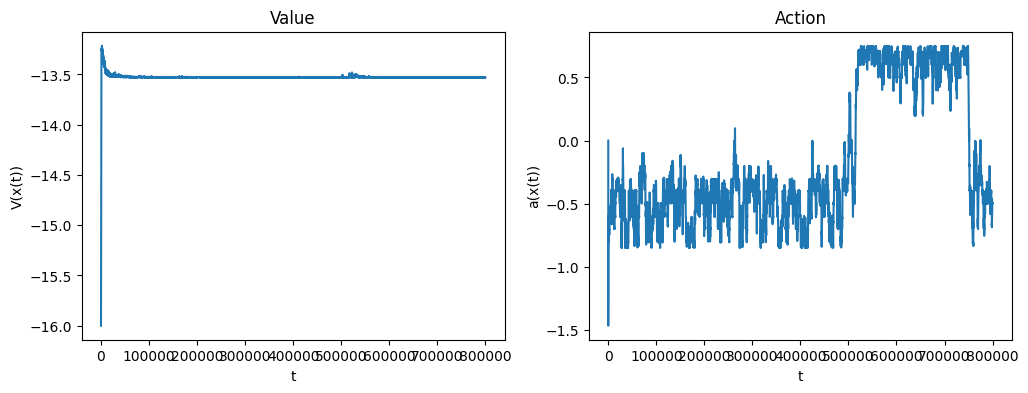

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(sim.data[value_probe], label='value')
ax[0].set_title('Value')
ax[0].set_ylabel('V(x(t))')
ax[0].set_xlabel('t')

ax[1].plot(sim.data[action_probe])
ax[1].set_title(f'Action')
ax[1].set_xlabel('t')
ax[1].set_ylabel('a(x(t))')

# plt.plot(sim.data[action_probe], label='action')
# plt.legend()

In [ ]:
# end = 1000
# plt.plot(sim.data[place_probe][:end], label='place')
# plt.plot(sim.data[state_probe][:end], label='state')
# plt.legend()

In [ ]:
# plt.plot(master.reward_history)
# plt.xlabel('Trial')
# plt.title('Total reward per trial')

Text(0.5, 0, 'Trial')

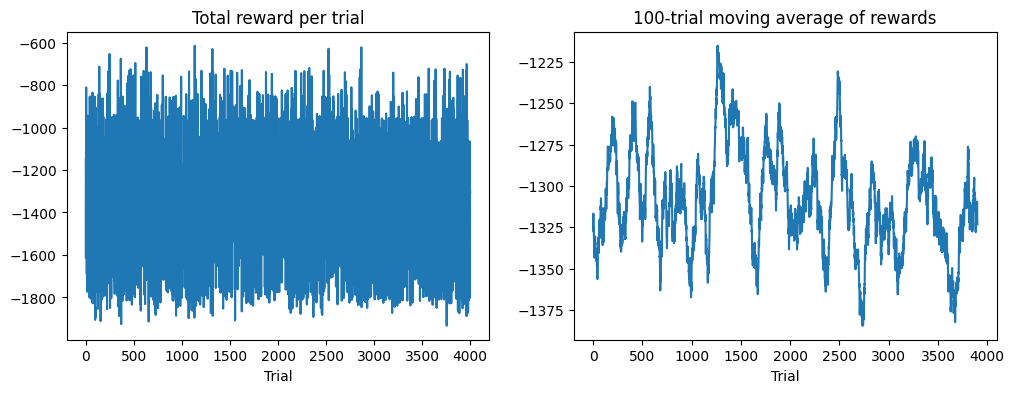

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(master.reward_history)
ax[0].set_xlabel('Trial')
ax[0].set_title('Total reward per trial')

h = 100
ax[1].plot(np.convolve(master.reward_history, np.ones(h)/h, 'valid'))
ax[1].set_title(f'{h}-trial moving average of rewards')
ax[1].set_xlabel('Trial')